In [ ]:
!pip install -U transformers datasets accelerate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 79.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 M

# Fine-tune

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# ============================================================
# LOAD FULL DATASET (không giới hạn)
# ============================================================
full_ds = load_dataset(
    "harouzie/vi_en-translation",
    split="train",
    token=""
).shuffle(seed=42)

# ============================================================
# CHIA TẬP TRAIN/VAL (5000 mẫu) + TEST (1000 mẫu KHÔNG TRÙNG)
# ============================================================

train_val_ds = full_ds.select(range(0, 5000))       # 5000 mẫu dành cho training + validation
test_ds      = full_ds.select(range(5000, 6000))    # 1000 mẫu riêng cho test (không trùng)

# Từ 5000 mẫu train_val → chia 90/10
split_ds = train_val_ds.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = split_ds["train"], split_ds["test"]

README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

data/train-00000-of-00001-8fc21cb8e80d3a(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/test-00000-of-00001-858c0e989d9c563(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

data/valid-00000-of-00001-99e7e50144d1c1(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

In [ ]:
print(train_ds)
print(eval_ds)
print(test_ds)
print("\nDữ liệu trong tập train:")
for i in range(3):
    print(f"\nEnglish: {train_ds[i]['English']}")
    print(f"Vietnamese: {train_ds[i]['Vietnamese']}")

Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 4500
})
Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 500
})
Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 1000
})

Dữ liệu trong tập train:

English: Is there a tennis court around here?
Vietnamese: Có một sân tennis quanh đây không?

English: I want you to promise me something.
Vietnamese: tôi muốn bạn hứa với tôi một cái gì đó

English: Thank you for your kind assistance.
Vietnamese: cảm ơn sự giúp đỡ của bạn


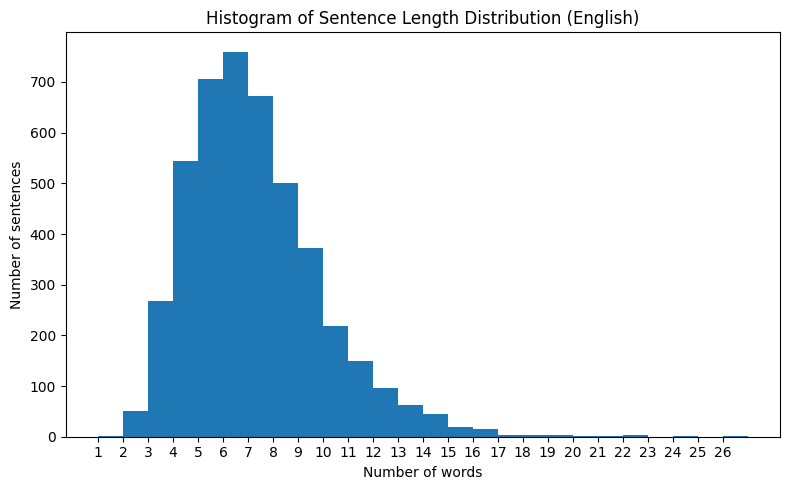

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sentence_lengths = [len(sample["English"].split()) for sample in train_ds]

max_len = max(sentence_lengths)

plt.figure(figsize=(8,5))
plt.hist(sentence_lengths, bins=range(1, max_len + 2))
plt.title("Histogram of Sentence Length Distribution (English)")
plt.xlabel("Number of words")
plt.ylabel("Number of sentences")
plt.xticks(range(1, max_len + 1))
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# LOAD TOKENIZER & MODEL (ViT5)
# ============================================================
model_id = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [ ]:
max_length = 128
prefix = "translate English to Vietnamese: "

def preprocess_function(examples):
    inputs = [prefix + ex for ex in examples["English"]]
    targets = [ex for ex in examples["Vietnamese"]]

    # Tokenize input
    model_inputs = tokenizer(
        inputs,
        max_length=max_length,
        padding="max_length",
        truncation=True
    )

    # Tokenize labels
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_length,
            padding="max_length",
            truncation=True
        )

    # Replace PAD = -100
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_eval  = eval_ds.map(preprocess_function, batched=True, remove_columns=eval_ds.column_names)

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
training_args = Seq2SeqTrainingArguments(
    output_dir="./vit5_envi_model/",
    num_train_epochs=3,
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_ratio=0.03,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    save_total_limit=1,
    report_to="none",
    fp16=False,
    bf16=False,
    predict_with_generate=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [ ]:
save_dir = "./vit5_envi_model/"
print(f"Lưu mô hình vào: {save_dir}")
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    "/kaggle/input/vit5-envi-model",
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/vit5-envi-model")

In [ ]:
def translate_en_to_vi(text):
    input_text = "translate English to Vietnamese: " + text
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,         # beam search
            length_penalty=1.0,  # giúp câu dài đủ, giảm rút gọn
            do_sample=False      # tắt sampling
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
test_sentences = [
    "He is a good teacher.",
    "She doesn’t like coffee.",
    "How are you today?",
    "Please speak more slowly.",
    "Do you have any questions?",
    "I’ll call you back later.",
    "I haven’t finished my homework yet.",
    "The weather is getting worse.",
    "It is expected to rain heavily tonight.",
    "Climate change is one of the biggest challenges of our time.",
    "The temperature dropped significantly this morning.",
    "The air quality is improving slowly.",
    "More people are working remotely than ever before.",
    "This book contains many useful lessons about life.",
    "The government is planning to introduce new policies next year.",
    "He promised that he would finish the work before the deadline.",
    "Although the weather was bad, we still decided to continue the trip.",
    "I finally realized that I had been making the same mistake over and over again.",
]
for s in test_sentences:
    print(f"\nEnglish: {s}")
    print(f"Vietnamese: {translate_en_to_vi(s)}")


English: He is a good teacher.
Vietnamese: anh ấy là một giáo viên tốt.

English: She doesn’t like coffee.
Vietnamese: cô ấy không thích cà phê.

English: How are you today?
Vietnamese: hôm nay bạn thế nào

English: Please speak more slowly.
Vietnamese: làm ơn nói chậm hơn

English: Do you have any questions?
Vietnamese: bạn có câu hỏi không?

English: I’ll call you back later.
Vietnamese: Tôi sẽ gọi lại cho bạn sau.

English: I haven’t finished my homework yet.
Vietnamese: tôi đã không hoàn thành bài tập về nhà của mình.

English: The weather is getting worse.
Vietnamese: thời tiết đang trở nên tồi tệ

English: It is expected to rain heavily tonight.
Vietnamese: nó có ý nghĩa lớn đối với ánh trăng tối nay.

English: Climate change is one of the biggest challenges of our time.
Vietnamese: hòa bình là một trong những điểm lớn nhất trong các hành trình của chúng ta trong thời gian tới.

English: The temperature dropped significantly this morning.
Vietnamese: dự báo thời tiết cho sáng na

# Synthetic Data

Qwen2-7B-Instruct

In [ ]:
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 32.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00:00:0100:01
  Attempting un

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "Qwen/Qwen2-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
def qwen_generate(prompt, max_tokens=512):
    text = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=0.7,
        top_p=0.9,
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
import re

def clean_output(raw):
    # Xóa các ký tự lạ ngoài ASCII + tiếng Việt
    raw = re.sub(r"[^\x00-\x7FÀ-ỹ\s.,!?\"'“”‘’\-:/()]", "", raw)
    # Xóa bớt khoảng trắng dư
    raw = re.sub(r"\s+", " ", raw)
    return raw.strip()

In [ ]:
def paraphrase_and_translate(sentence):
    prompt = f"""
Paraphrase the following English sentence.
Then translate the paraphrased version into Vietnamese.

Output EXACTLY in this format:

EN: <paraphrased English sentence>
VI: <Vietnamese translation>

Sentence:
"{sentence}"
"""

    raw = qwen_generate(prompt, max_tokens=300)
    raw = clean_output(raw)

    # 1) Tìm phần sau chữ "assistant"
    match = re.search(r"assistant\s+EN:(.+?)VI:(.+)", raw)
    if match:
        en = match.group(1).strip()
        vi = match.group(2).strip()
        return {"English": en, "Vietnamese": vi}

    print("Output không đúng format:\n", raw)
    return None

In [ ]:
print("=== TEST: paraphrase_and_translate ===")

test_sentences = [
    "I love playing football.",
    "The weather is very hot today.",
    "She is studying at the university.",
    "Is there a tennis court around here?",
    "What would you do if you had ten thousand dollars?"
]

for s in test_sentences:
    print(paraphrase_and_translate(s))

=== TEST: paraphrase_and_translate ===
{'English': 'My favorite leisure activity is playing football.', 'Vietnamese': 'môn thể thao yêu thích của tôi là chơi bóng đá.'}
{'English': 'The heat of the day is extremely high.', 'Vietnamese': 'Nhiệt độ hôm nay rất cao.'}
{'English': 'She is attending university.', 'Vietnamese': 'Cô ấy đang học tại trường đại học.'}
{'English': 'Are there any tennis courts nearby?', 'Vietnamese': 'Có các sân tennis nào ở gần đây không?'}
{'English': 'If you had ten thousand dollars, what action would you take?', 'Vietnamese': 'Nếu bạn có mười nghìn đô la, hành động bạn sẽ thực hiện là gì?'}


In [ ]:
import re

def similar_and_translate(seed_list, num_new=50):
    seed_text = "\n".join([f"- {s}" for s in seed_list])

    prompt = f"""
Generate {num_new} NEW English sentences that are similar in TOPIC
to the examples below (NOT paraphrases).
Then translate each new English sentence into Vietnamese.

Return EACH pair in the EXACT format:

EN: <new English sentence>
VI: <Vietnamese translation>

Do NOT repeat anything else.
Do NOT print explanations.
Do NOT print the examples.

Examples for topics:
{seed_text}
"""

    raw = qwen_generate(prompt, max_tokens=2000)
    raw = clean_output(raw)

    # Chỉ lấy phần sau "assistant"
    assistant_idx = raw.lower().rfind("assistant")
    if assistant_idx != -1:
        raw = raw[assistant_idx + len("assistant"):].strip()

    # Match EN/VI chính xác
    matches = re.findall(r"EN:\s*(.*?)\s*VI:\s*(.*?)(?=EN:|$)", raw)

    results = []
    for en, vi in matches:
        en = en.strip()
        vi = vi.strip()
        if en and vi:
            results.append({"English": en, "Vietnamese": vi})

    if not results:
        print("Không tìm thấy EN/VI trong output:\n", raw)

    return results


In [ ]:
print("=== TEST: similar_and_translate ===")

seed_examples = [
    "The government is building new hospitals.",
    "People are becoming more aware of climate change.",
    "She is studying at the university.",
    "Is there a tennis court around here?",
    "What would you do if you had ten thousand dollars?"
]

result2 = similar_and_translate(seed_examples, num_new=5)
for r in result2:
    print(r)


=== TEST: similar_and_translate ===
{'English': 'The city council has approved plans to construct additional schools.', 'Vietnamese': 'Hội đồng thành phố đã phê duyệt kế hoạch xây dựng thêm các trường học.'}
{'English': 'Many consumers are now choosing eco-friendly products.', 'Vietnamese': 'Nhiều người tiêu dùng giờ đây đang chọn các sản phẩm thân thiện với môi trường.'}
{'English': 'He is pursuing a degree in computer science.', 'Vietnamese': 'Anh ấy đang theo đuổi bằng cấp trong khoa học máy tính.'}
{'English': 'Where can I find a nearby gym?', 'Vietnamese': 'Tôi có thể tìm ra phòng tập gym gần nhất ở đâu không?'}
{'English': 'If you won the lottery, what would be your first purchase?', 'Vietnamese': 'Nếu bạn trúng xổ số, mua thứ đầu tiên của bạn sẽ là gì?'}


In [ ]:
def similar_bulk(seed_list, total=300, batch=20):
    all_results = []
    loops = total // batch

    for i in range(loops):
        print(f"Batch {i+1}/{loops} ...")
        part = similar_and_translate(seed_list, num_new=batch)
        all_results.extend(part)

    remain = total % batch
    if remain > 0:
        print(f"Batch cuối: {remain} câu ...")
        part = similar_and_translate(seed_list, num_new=remain)
        all_results.extend(part)

    return all_results

In [ ]:
import re

def expand_dataset(batch_size=50):
    prompt = f"""
Generate {batch_size} English–Vietnamese translation pairs.

Strict requirements:
- English sentence MUST BE 8–25 words.
- Vietnamese sentence MUST BE 8–25 words.
- Sentences must be natural, fluent, meaningful.
- Diverse topics: daily life, education, technology, science, society.

Return EACH pair in EXACT format:

EN: <English sentence>
VI: <Vietnamese sentence>

Do NOT add explanations.
"""

    raw = qwen_generate(prompt, max_tokens=2000)
    raw = clean_output(raw)

    # --- Chỉ lấy phần sau "assistant" ---
    assistant_idx = raw.lower().rfind("assistant")
    if assistant_idx != -1:
        raw = raw[assistant_idx + len("assistant"):].strip()

    # --- Parse EN: VI: pairs ---
    matches = re.findall(r"EN:\s*(.*?)\s*VI:\s*(.*?)(?=EN:|$)", raw)

    results = []
    for en, vi in matches:
        en = en.strip()
        vi = vi.strip()
        if en and vi:
            results.append({"English": en, "Vietnamese": vi})

    if not results:
        print("Không tìm thấy EN/VI trong output:\n", raw)

    return results


In [ ]:
print("\n=== TEST: expand_dataset ===")
result3 = expand_dataset(batch_size=5)
for r in result3:
    print(r)


=== TEST: expand_dataset ===
{'English': 'I enjoy reading books in my free time.', 'Vietnamese': 'Tôi thích đọc sách trong thời gian rảnh.'}
{'English': 'The new smartphone has impressive features.', 'Vietnamese': 'Smartphone mới có những tính năng ấn tượng.'}
{'English': 'She is an excellent student with high grades.', 'Vietnamese': 'Cô ấy là một học sinh xuất sắc với điểm cao.'}
{'English': 'The scientist discovered a new element recently.', 'Vietnamese': 'Nhà khoa học đã phát hiện ra một nguyên tố mới gần đây.'}
{'English': 'Online learning platforms are gaining popularity.', 'Vietnamese': 'Các nền tảng học tập trực tuyến đang ngày càng phổ biến.'}


In [ ]:
def expand_bulk(total=600, batch=30):
    all_results = []
    loops = total // batch

    for i in range(loops):
        print(f"[EXPAND] Batch {i+1}/{loops} ...")
        part = expand_dataset(batch_size=batch)
        all_results.extend(part)

    remain = total % batch
    if remain > 0:
        print(f"[EXPAND] Last batch: {remain} ...")
        part = expand_dataset(batch_size=remain)
        all_results.extend(part)

    return all_results

In [ ]:
import torch, json, time, random
seed_english = [train_ds[i]["English"] for i in random.sample(range(len(train_ds)), 200)]

In [ ]:
paraphrase_result = []

for s in seed_english[:200]:
    res = paraphrase_and_translate(s)   # <-- truyền string, không phải list
    if isinstance(res, dict):           # <-- res là dict
        paraphrase_result.append(res)   # <-- thêm dict vào list

In [ ]:
similar_result = similar_bulk(seed_english[:10], total=300, batch=20)

In [ ]:
expand_result = expand_bulk(total=600, batch=20)

In [ ]:
synthetic_all = paraphrase_result + similar_result + expand_result
print("Tổng synthetic:", len(synthetic_all))

In [ ]:
from datasets import Dataset

synthetic_ds = Dataset.from_list(synthetic_all)
print(synthetic_ds)

In [ ]:
synthetic_ds.to_json("synthetic_dataset.json", force_ascii=False)

In [ ]:
from datasets import load_dataset

synthetic_ds = load_dataset(
    "json",
    data_files="/kaggle/input/synthetic-datasetv3-json/synthetic_datasetV3.json",
    split="train"
)

print("Synthetic loaded:", len(synthetic_ds))
for i in range(5):
    print(synthetic_ds[i])

Generating train split: 0 examples [00:00, ? examples/s]

Synthetic loaded: 2000
{'English': 'He positioned himself with his legs spread.', 'Vietnamese': 'Anh ta đứng dang rộng hai chân.'}
{'English': '"Just one is enough"', 'Vietnamese': '"Chỉ cần một là đủ"'}
{'English': "It's difficult for me to picture him traveling overseas.", 'Vietnamese': 'Thật khó để tôi hình dung anh ấy đi du lịch nước ngoài.'}
{'English': "Tom was aware of Mary's wealth.", 'Vietnamese': 'Tom biết rằng Mary rất giàu có.'}
{'English': '"Jiro is taller than everyone else except Taro."', 'Vietnamese': '"Jiro cao hơn mọi người trừ Taro."'}


In [ ]:
from datasets import concatenate_datasets

augmented_train_ds = concatenate_datasets([train_ds, synthetic_ds])

In [ ]:
print("Original train:", len(train_ds))
print("Synthetic:", len(synthetic_ds))
print("Augmented train:", len(augmented_train_ds))

Original train: 4500
Synthetic: 2000
Augmented train: 6500


In [ ]:
print(augmented_train_ds)
print("=== FIRST 5 SAMPLES ===")
for i in range(5):
    print(augmented_train_ds[i])

print("\n=== LAST 5 SAMPLES (Synthetic) ===")
for i in range(-5, 0):
    print(augmented_train_ds[i])

Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 6500
})
=== FIRST 5 SAMPLES ===
{'English': 'Is there a tennis court around here?', 'Vietnamese': 'Có một sân tennis quanh đây không?'}
{'English': 'I want you to promise me something.', 'Vietnamese': 'tôi muốn bạn hứa với tôi một cái gì đó'}
{'English': 'Thank you for your kind assistance.', 'Vietnamese': 'cảm ơn sự giúp đỡ của bạn'}
{'English': 'Tom got up and went into the other room', 'Vietnamese': 'tom đứng dậy và đi vào phòng khác'}
{'English': 'What would you do if you had ten thousand dollars?', 'Vietnamese': 'Bạn sẽ làm gì nếu bạn có mười nghìn đô la?'}

=== LAST 5 SAMPLES (Synthetic) ===
{'English': 'We sat under a tree and enjoyed the cool breeze.', 'Vietnamese': 'Chúng tôi ngồi dưới gốc cây và tận hưởng làn gió mát.'}
{'English': 'He listened to ambient music while studying.', 'Vietnamese': 'Anh ấy nghe nhạc nhẹ nhàng trong lúc học.'}
{'English': 'I noticed the stars were unusually bright that night.', 'Vietna

In [ ]:
print("Augmented train:", len(augmented_train_ds))
print("Eval giữ nguyên:", len(eval_ds))
print("Test giữ nguyên:", len(test_ds))

Augmented train: 6500
Eval giữ nguyên: 500
Test giữ nguyên: 1000


# Fine-tune Synthetic Data

In [ ]:
# ============================================================
# LOAD TOKENIZER & MODEL (ViT5)
# ============================================================
model_id = "VietAI/vit5-base"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

2025-11-14 16:32:06.239582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763137926.418038      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763137926.467548      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [ ]:
max_length = 128
prefix = "translate English to Vietnamese: "

def preprocess_function(examples):
    inputs = [prefix + ex for ex in examples["English"]]
    targets = [ex for ex in examples["Vietnamese"]]

    # Tokenize input
    model_inputs = tokenizer(
        inputs,
        max_length=max_length,
        padding="max_length",
        truncation=True
    )

    # Tokenize labels
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_length,
            padding="max_length",
            truncation=True
        )

    # Replace PAD = -100
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = augmented_train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_eval  = eval_ds.map(preprocess_function, batched=True, remove_columns=eval_ds.column_names)

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train[0]["labels"][:20])

[1457, 68, 1182, 19878, 1494, 642, 129, 35933, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
training_args = Seq2SeqTrainingArguments(
    output_dir="./vit5_envi_synthetic/",
    num_train_epochs=3,
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_ratio=0.03,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    save_total_limit=1,
    report_to="none",
    fp16=False,
    bf16=False,
    predict_with_generate=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

/tmp/ipykernel_48/3875996261.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
print("Sample input_ids:", tokenized_train[0]["input_ids"][:20])
print("Sample labels:", tokenized_train[0]["labels"][:20])

Sample input_ids: [31286, 2722, 14071, 1904, 3844, 5071, 35862, 1491, 28501, 2071, 19878, 7, 7390, 4097, 7582, 14, 4398, 35933, 1, 0]
Sample labels: [1457, 68, 1182, 19878, 1494, 642, 129, 35933, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [ ]:
trainer.train()

In [ ]:
save_dir = "./vit5_envi_synthetic/"
print(f"Lưu mô hình vào: {save_dir}")
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

Lưu mô hình vào: ./vit5_envi_synthetic/


('./vit5_envi_synthetic/tokenizer_config.json',
 './vit5_envi_synthetic/special_tokens_map.json',
 './vit5_envi_synthetic/spiece.model',
 './vit5_envi_synthetic/added_tokens.json',
 './vit5_envi_synthetic/tokenizer.json')

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    "./vit5_envi_synthetic/",
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained("./vit5_envi_synthetic/")

`torch_dtype` is deprecated! Use `dtype` instead!
The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


In [ ]:
def translate_en_to_vi(text):
    input_text = "translate English to Vietnamese: " + text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,
            temperature=0.7,
            top_p=0.9
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
test_sentences = [
    "He is a good teacher.",
    "She doesn’t like coffee.",
    "How are you today?",
    "Please speak more slowly.",
    "Do you have any questions?",
    "I’ll call you back later.",
    "I haven’t finished my homework yet.",
    "The weather is getting worse.",
    "It is expected to rain heavily tonight.",
    "Climate change is one of the biggest challenges of our time.",
    "The temperature dropped significantly this morning.",
    "The air quality is improving slowly.",
    "More people are working remotely than ever before.",
    "This book contains many useful lessons about life.",
    "The government is planning to introduce new policies next year.",
    "He promised that he would finish the work before the deadline.",
    "Although the weather was bad, we still decided to continue the trip.",
    "I finally realized that I had been making the same mistake over and over again.",
]
for s in test_sentences:
    print(f"\nEnglish: {s}")
    print(f"Vietnamese: {translate_en_to_vi(s)}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



English: He is a good teacher.
Vietnamese: anh ấy là một giáo viên tốt

English: She doesn’t like coffee.
Vietnamese: Cô ấy không thích cà phê.

English: How are you today?
Vietnamese: hôm nay bạn có khỏe không

English: Please speak more slowly.
Vietnamese: xin hãy nói chậm hơn

English: Do you have any questions?
Vietnamese: bạn có câu hỏi nào không?

English: I’ll call you back later.
Vietnamese: Tôi sẽ gọi cho bạn sau.

English: I haven’t finished my homework yet.
Vietnamese: tôi chưa hoàn thành bài tập nhà

English: The weather is getting worse.
Vietnamese: thời tiết đang trở lạnh.

English: It is expected to rain heavily tonight.
Vietnamese: trời đang có xu hướng mưa vào ban đêm.

English: Climate change is one of the biggest challenges of our time.
Vietnamese: Đổi khí là một trong những thách thức lớn nhất của thời gian.

English: The temperature dropped significantly this morning.
Vietnamese: Nhiệt độ giảm đột ngột sáng nay.

English: The air quality is improving slowly.
Vietn

In [ ]:
import torch
import sacrebleu
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ============================================================
# LOAD BASELINE MODEL
# ============================================================
baseline_path = "/kaggle/input/vit5-envi-model"     # bạn đổi nếu khác
model_base = AutoModelForSeq2SeqLM.from_pretrained(
    baseline_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tok_base = AutoTokenizer.from_pretrained(baseline_path)

# ============================================================
# LOAD SYNTHETIC MODEL
# ============================================================
synthetic_path = "./vit5_envi_synthetic/"           # thư mục bạn vừa train
model_syn = AutoModelForSeq2SeqLM.from_pretrained(
    synthetic_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tok_syn = AutoTokenizer.from_pretrained(synthetic_path)

print("Đã load 2 model thành công.")

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


Đã load 2 model thành công.


In [ ]:
# ------------------------------------------------------------
# Hàm dịch
# ------------------------------------------------------------
def translate_batch(model, tokenizer, texts):
    translations = []
    for text in texts:
        input_text = "translate English to Vietnamese: " + text

        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            truncation=True,
            max_length=128
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                num_beams=4,
                do_sample=False
            )

        trans = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translations.append(trans)

    return translations


# ============================================================
# DỊCH TOÀN BỘ TẬP TEST
# ============================================================
print("\n======= Translating with BASELINE model =======")
pred_base = translate_batch(model_base, tok_base, test_ds["English"])

print("\n======= Translating with SYNTHETIC model =======")
pred_syn = translate_batch(model_syn, tok_syn, test_ds["English"])

references = [[vi for vi in test_ds["Vietnamese"]]]


# ============================================================
# TÍNH BLEU
# ============================================================
bleu_base = sacrebleu.corpus_bleu(pred_base, references).score
bleu_syn  = sacrebleu.corpus_bleu(pred_syn, references).score

print("\n===== BLEU SCORE COMPARISON =====")
print(f"Baseline model BLEU : {bleu_base:.2f}")
print(f"Synthetic model BLEU: {bleu_syn:.2f}")
print(f"Tăng: {bleu_syn - bleu_base:.2f} BLEU")


# ============================================================
# IN RA MẪU
# ============================================================
print("\n===== SAMPLE COMPARISON =====")
for i in range(10):
    print("\n-------------------------------------")
    print(f"EN : {test_ds['English'][i]}")
    print(f"BASE: {pred_base[i]}")
    print(f"SYN : {pred_syn[i]}")
    print(f"REF : {test_ds['Vietnamese'][i]}")


======= Translating with BASELINE model =======

======= Translating with SYNTHETIC model =======

===== BLEU SCORE COMPARISON =====
Baseline model BLEU : 42.38
Synthetic model BLEU: 45.67
Tăng: 3.29 BLEU

===== SAMPLE COMPARISON =====

-------------------------------------
EN : We are anxious about her health.
BASE: chúng tôi đang lo lắng về sức khỏe của cô ấy
SYN : Chúng tôi lo lắng về sức khỏe của cô ấy.
REF : chúng tôi lo lắng về sức khỏe của cô ấy

-------------------------------------
EN : Once you get to know her, she is very friendly
BASE: kể từ khi bạn biết cô ấy, cô ấy rất thân
SYN : khi bạn biết cô ấy, cô ấy rất thân thiết
REF : Một khi bạn quen cô ấy, cô ấy rất thân thiện.

-------------------------------------
EN : I'll see you in a little while
BASE: tôi sẽ gặp bạn sau
SYN : tôi sẽ gặp bạn sau
REF : tôi sẽ gặp bạn sau

-------------------------------------
EN : I will leave it to your judgement
BASE: tôi sẽ đưa nó cho giáo viên của bạn
SYN : tôi sẽ từ bỏ nó
REF : tôi sẽ 

In [ ]:
# ============================================================
# TẠO FILE JSONL CHO LLM EVALUATION
# Format: {"src": ..., "pred": ..., "ref": ...}
# ============================================================
import json
samples_base = []
samples_syn  = []

for src, ref, p_base, p_syn in zip(
    test_ds["English"],
    test_ds["Vietnamese"],
    pred_base,
    pred_syn
):
    samples_base.append({
        "src": src,
        "pred": p_base,
        "ref":  ref
    })

    samples_syn.append({
        "src": src,
        "pred": p_syn,
        "ref":  ref
    })

# Xuất ra JSONL
out_base = "/kaggle/working/eval_base_for_llm.jsonl"
out_syn  = "/kaggle/working/eval_syn_for_llm.jsonl"

with open(out_base, "w", encoding="utf-8") as f:
    for ex in samples_base:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

with open(out_syn, "w", encoding="utf-8") as f:
    for ex in samples_syn:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print("\n===== FILES CREATED FOR LLM EVALUATION =====")
print("Baseline  →", out_base)
print("Synthetic →", out_syn)
print("============================================\n")


===== FILES CREATED FOR LLM EVALUATION =====
Baseline  → /kaggle/working/eval_base_for_llm.jsonl
Synthetic → /kaggle/working/eval_syn_for_llm.jsonl



# Evaluation

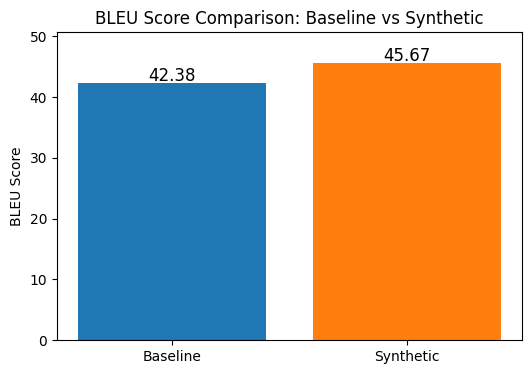

In [ ]:
import matplotlib.pyplot as plt

models = ["Baseline", "Synthetic"]
scores = [bleu_base, bleu_syn]

# ============================================
# Vẽ biểu đồ
# ============================================
plt.figure(figsize=(6,4))
plt.bar(models, scores, color=["#1f77b4", "#ff7f0e"])  # màu xanh & cam
plt.title("BLEU Score Comparison: Baseline vs Synthetic")
plt.ylabel("BLEU Score")
plt.ylim(0, max(scores) + 5)

# Hiển thị giá trị trên từng cột
for i, v in enumerate(scores):
    plt.text(i, v + 0.3, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

Test thử coi model Qwen2-7B-Instruct có oke hơn của Meta không

In [ ]:
!pip install bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 28.8 MB/s eta 0:00:00:00:0100:01


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, re, json

model_id = "Qwen/Qwen2-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
def extract_json(text):
    # Xóa code fence
    text = text.replace("```json", "").replace("```", "").strip()

    # Tìm JSON đầu tiên
    matches = re.findall(r"\{[^{}]*\}", text)

    if not matches:
        return None

    for m in matches:
        try:
            obj = json.loads(m)
            if "meaning" in obj and "fluency" in obj:
                return obj
        except:
            continue

    return None


# LLM-based evaluation

In [ ]:
def judge_qwen(src, pred, ref=None, max_tokens=64):

    prompt = f"""
Return ONLY one JSON rating the translation.

meaning = faithfulness to English meaning (0–10)
fluency = natural Vietnamese (0–10)

STRICT RULE (meaning):
- If the translation reverses meaning, changes direction (better ↔ worse, but ↔ and),
  or contradicts the English source → meaning MUST be between 0 and 2.
- Otherwise: meaning = 5–10 depending on accuracy.

Return EXACTLY this:
{{"meaning": number, "fluency": number}}

English: {src}
Output: {pred}
Reference: {ref}

JSON:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Stop when '}' xuất hiện
    stop_id = tokenizer.convert_tokens_to_ids("}")

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            eos_token_id=stop_id,
            do_sample=True,
            temperature=0.3,
            top_p=0.9,
        )

    text = tokenizer.decode(output[0], skip_special_tokens=True) + "}"

    data = extract_json(text)
    if data:
        data["overall"] = (data["meaning"] + data["fluency"]) / 2

    return data, text


In [ ]:
samples = [
    {
        "src": "He forgot to lock the door before leaving the house.",
        "pred": "Anh ấy quên khóa cửa trước khi rời khỏi nhà.",
        "ref":  "Anh ấy đã quên khóa cửa trước khi ra khỏi nhà."
    },
    {
        "src": "The weather has become unpredictable due to climate change.",
        "pred": "Thời tiết đã trở nên khó đoán do biến đổi khí hậu.",
        "ref":  "Do biến đổi khí hậu, thời tiết trở nên khó dự đoán."
    },
    {
        "src": "She finished the report earlier than expected.",
        "pred": "Cô ấy hoàn thành báo cáo sớm hơn dự kiến.",
        "ref":  "Cô ấy đã hoàn thành bản báo cáo sớm hơn so với dự định."
    },

    {
        "src": "They decided to cancel the trip due to the storm.",
        "pred": "Họ quyết định hủy chuyến đi vì cơn bão.",
        "ref":  "Họ đã quyết định hủy chuyến đi do có bão."
    },

    {
        "src": "He admitted that he had made a serious mistake.",
        "pred": "Anh ấy thừa nhận mình đã mắc lỗi.",
        "ref":  "Anh ấy thừa nhận rằng mình đã mắc một sai lầm nghiêm trọng."
    },
        {
        "src": "He tried to fix the issue, but it got worse.",
        "pred": "Anh ấy cố gắng sửa vấn đề, và nó đã tốt hơn.",
        "ref":  "Anh ấy cố gắng sửa vấn đề, nhưng nó trở nên tệ hơn."
    },
    {
        "src": "The temperature dropped sharply overnight.",
        "pred": "Nhiệt độ tăng mạnh chỉ sau một đêm.",
        "ref":  "Nhiệt độ giảm mạnh chỉ sau một đêm."
    },
    {
        "src": "She refused to sign the contract.",
        "pred": "Cô ấy đồng ý ký hợp đồng.",
        "ref":  "Cô ấy từ chối ký hợp đồng."
    },
    {
        "src": "The medicine caused severe side effects.",
        "pred": "Thuốc này hoàn toàn không gây tác dụng phụ.",
        "ref":  "Loại thuốc này gây ra tác dụng phụ nghiêm trọng."
    },
    {
        "src": "The project was canceled due to lack of funding.",
        "pred": "Dự án được mở rộng vì có nhiều kinh phí.",
        "ref":  "Dự án bị hủy vì thiếu kinh phí."
    }
]

for i, ex in enumerate(samples, start=1):
    score, raw = judge_qwen(ex["src"], ex["pred"], ex["ref"])
    print(f"\n===== SAMPLE {i} =====")
    print("Score:", score)
    print("Raw output:", raw)



===== SAMPLE 1 =====
Score: {'meaning': 8, 'fluency': 9, 'overall': 8.5}
Raw output: 
Return ONLY one JSON rating the translation.

meaning = faithfulness to English meaning (0–10)
fluency = natural Vietnamese (0–10)

STRICT RULE (meaning):
- If the translation reverses meaning, changes direction (better ↔ worse, but ↔ and),
  or contradicts the English source → meaning MUST be between 0 and 2.
- Otherwise: meaning = 5–10 depending on accuracy.

Return EXACTLY this:
{"meaning": number, "fluency": number}

English: He forgot to lock the door before leaving the house.
Output: Anh ấy quên khóa cửa trước khi rời khỏi nhà.
Reference: Anh ấy đã quên khóa cửa trước khi ra khỏi nhà.

JSON:
{"meaning": 8, "fluency": 9}}

===== SAMPLE 2 =====
Score: {'meaning': 9, 'fluency': 8, 'overall': 8.5}
Raw output: 
Return ONLY one JSON rating the translation.

meaning = faithfulness to English meaning (0–10)
fluency = natural Vietnamese (0–10)

STRICT RULE (meaning):
- If the translation reverses meanin

In [ ]:
import json

def eval_with_qwen(input_path, output_path, limit=500):
    print(f"\n=== Đang chấm file: {input_path} ===")

    count = 0

    with open(input_path, "r", encoding="utf-8") as f_in, \
         open(output_path, "w", encoding="utf-8") as f_out:

        for line in f_in:
            if count >= limit:
                break

            ex = json.loads(line)

            score, raw = judge_qwen(ex["src"], ex["pred"], ex["ref"])

            ex["score"] = score
            f_out.write(json.dumps(ex, ensure_ascii=False) + "\n")

            count += 1
            print(f"  -> Done {count}", end="\r")

    print(f"\n=== DONE. Saved to: {output_path} ===\n")

In [ ]:
# ============================================================
# CHẤM BASELINE (500 câu)
# ============================================================
eval_with_qwen(
    "/kaggle/working/eval_base_for_llm.jsonl",
    "/kaggle/working/eval_base_qwen_score.jsonl",
    limit=500
)


=== Đang chấm file: /kaggle/working/eval_base_for_llm.jsonl ===
  -> Done 500
=== DONE. Saved to: /kaggle/working/eval_base_qwen_score.jsonl ===



In [ ]:
# ============================================================
# CHẤM SYNTHETIC (500 câu)
# ============================================================
eval_with_qwen(
    "/kaggle/working/eval_syn_for_llm.jsonl",
    "/kaggle/working/eval_syn_qwen_score.jsonl",
    limit=500
)


=== Đang chấm file: /kaggle/working/eval_syn_for_llm.jsonl ===
  -> Done 500
=== DONE. Saved to: /kaggle/working/eval_syn_qwen_score.jsonl ===



In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# 1) LOAD SCORE TỪ FILE QWEN 500
# ============================================
def load_scores(path):
    scores = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            scores.append(obj["score"])
    return scores

base_scores = load_scores("/kaggle/working/eval_base_qwen_score.jsonl")
syn_scores  = load_scores("/kaggle/working/eval_syn_qwen_score.jsonl")

In [ ]:
# ============================================
# 2) HÀM TÍNH TRUNG BÌNH
# ============================================
def avg(values, key):
    return sum(v[key] for v in values) / len(values)

base_meaning = avg(base_scores, "meaning")
base_fluency = avg(base_scores, "fluency")
base_overall = avg(base_scores, "overall")

syn_meaning  = avg(syn_scores, "meaning")
syn_fluency  = avg(syn_scores, "fluency")
syn_overall  = avg(syn_scores, "overall")

print("===== QWEN EVALUATION (500 samples) =====")
print(f"Baseline - meaning: {base_meaning:.2f}, fluency: {base_fluency:.2f}, overall: {base_overall:.2f}")
print(f"Synthetic - meaning: {syn_meaning:.2f}, fluency: {syn_fluency:.2f}, overall: {syn_overall:.2f}")

===== QWEN EVALUATION (500 samples) =====
Baseline - meaning: 7.06, fluency: 7.23, overall: 7.15
Synthetic - meaning: 7.19, fluency: 7.38, overall: 7.29


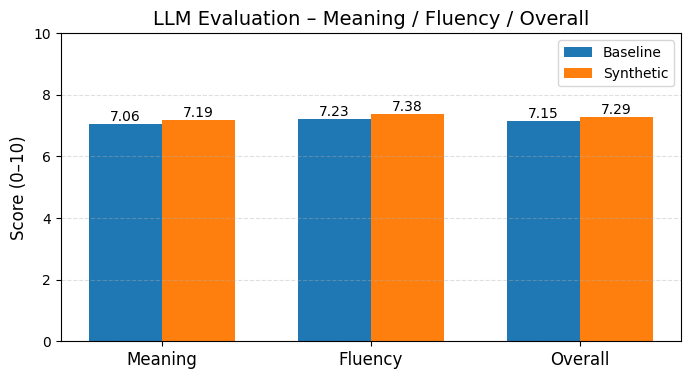

In [ ]:
# ============================================
# 3) VẼ BIỂU ĐỒ SO SÁNH
# ============================================
labels = ["Meaning", "Fluency", "Overall"]
baseline_scores = [base_meaning, base_fluency, base_overall]
synthetic_scores = [syn_meaning, syn_fluency, syn_overall]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, baseline_scores, width, label="Baseline")
plt.bar(x + width/2, synthetic_scores, width, label="Synthetic")

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Score (0–10)", fontsize=12)
plt.title("LLM Evaluation – Meaning / Fluency / Overall", fontsize=14)
plt.ylim(0, 10)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for i, v in enumerate(baseline_scores):
    plt.text(i - width/2, v + 0.1, f"{v:.2f}", ha='center')

for i, v in enumerate(synthetic_scores):
    plt.text(i + width/2, v + 0.1, f"{v:.2f}", ha='center')

plt.show()